### 3. MNIST and CNN Experiments [3 marks]
Train on MNIST dataset using an MLP. The original training dataset contains 60,000 images and the test contains 10,000 images. If you are short on compute, use a stratified subset of a smaller number of images but keep the same test set. Your MLP has 30 neurons in the first layer, 20 in the second layer and then 10 finally for the output layer (corresponding to 10 classes)

- Compare against Random Forest and Logistic Regression. The metrics can be: accuracy, F1-score, confusion matrix. Write your observations and discuss misclassifications.

### Importing Libraries

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import joblib

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image




In [26]:
# device configuration
print('Using PyTorch version:', torch.__version__)
if torch.cuda.is_available():
    print('Using GPU, device name:', torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found, using CPU instead.')
    device = torch.device('cpu')


Using PyTorch version: 2.8.0+cu126
Using GPU, device name: Tesla T4


In [27]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)

set_seed(42)

### Loading the MNIST Dataset

In [28]:
# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
# Flatten the images for sklearn MLP
X_train = train_dataset.data.numpy()
y_train = train_dataset.targets.numpy()
X_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()


print('Training set shape:', X_train.shape)
print('Test set shape:', X_test.shape)

Training set shape: (60000, 28, 28)
Test set shape: (10000, 28, 28)


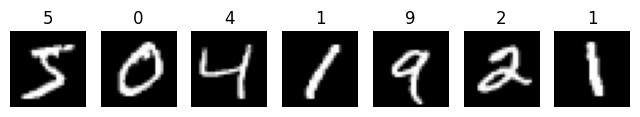

In [29]:
fig, axs = plt.subplots(1, 7, figsize=(8, 10))
for i in range(7):
    axs[i].imshow(X_train[i], cmap='gray')
    axs[i].set_title(y_train[i])
    axs[i].axis('off')

In [30]:
batch_size = 60
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In this section, we train a simple MLP model on the MNIST dataset of handwritten digits. The architecture of the MLP is as follows:

| Layer | Number of neurons |
|------------|----------|
| Input Layer | 784 neurons |
| Hidden Layer 1 | 30 neurons |
| Hidden Layer 2 | 20 neurons |
| Output Layer | 10 neurons |

We use the cross-entropy loss function and Adam as the optimizer. We have used ReLU as the activation function for the hidden layer and softmax for the output layer. The loss function expects logits that's why the softmax hasnt been applied in the neural network.

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_size=784, hidden1=30, hidden2=20, num_classes=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [32]:
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
print(model)

summary(model, (1, 28, 28))

MLP(
  (fc1): Linear(in_features=784, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 30]          23,550
            Linear-2                   [-1, 20]             620
            Linear-3                   [-1, 10]             210
Total params: 24,380
Trainable params: 24,380
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.09
Estimated Total Size (MB): 0.10
----------------------------------------------------------------


### Train Function

In [33]:
def train_and_evaluate_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_train_loss += loss.item()

            # Backward and optimize
            loss.backward()
            optimizer.step()

            # Store predictions and true labels
            _, predicted = torch.max(outputs.data, 1)
            y_train_pred = predicted.cpu().numpy()
            y_train_true = labels.cpu().numpy()
            y_train_prob = F.softmax(outputs, dim=1).cpu().detach().numpy()
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = 100 * correct_train / total_train
        train_loss = total_train_loss / len(train_loader)

        # Evaluate on test data
        model.eval()
        total_test_loss = 0
        correct_test = 0
        total_test = 0



        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_test_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                y_test_pred = predicted.cpu().numpy()
                y_test_true = labels.cpu().numpy()
                y_test_prob = F.softmax(outputs, dim=1).cpu().detach().numpy()
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_accuracy = 100 * correct_test / total_test
        test_loss = total_test_loss / len(test_loader)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Train Accuracy: {train_accuracy:.4f}%, Test Loss: {test_loss:.6f}, Test Accuracy: {test_accuracy:.4f}%')

    return model, train_loss, train_accuracy, test_loss, test_accuracy, y_train_true, y_train_pred, y_train_prob, y_test_true, y_test_pred, y_test_prob


### Training the MLP model

In [ ]:
model, train_loss, train_accuracy, test_loss, test_accuracy, y_train, y_train_pred, y_train_prob, y_test, y_test_pred, y_test_prob = train_and_evaluate_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs=10)

Epoch [10/60], Train Loss: 0.113881, Train Accuracy: 96.7817%, Test Loss: 0.184854, Test Accuracy: 95.7200%
Epoch [20/60], Train Loss: 0.088951, Train Accuracy: 97.5717%, Test Loss: 0.196435, Test Accuracy: 96.2200%
Epoch [30/60], Train Loss: 0.083705, Train Accuracy: 97.7333%, Test Loss: 0.207141, Test Accuracy: 96.1100%
Epoch [40/60], Train Loss: 0.075248, Train Accuracy: 98.0967%, Test Loss: 0.257190, Test Accuracy: 95.5900%
Epoch [50/60], Train Loss: 0.072590, Train Accuracy: 98.1717%, Test Loss: 0.290707, Test Accuracy: 96.2700%
Epoch [60/60], Train Loss: 0.069188, Train Accuracy: 98.3000%, Test Loss: 0.285005, Test Accuracy: 96.2400%


### Predict Function

In [35]:
def predict_model(model, test_loader):
    model.eval()
    y_test_pred = []
    y_test_true = []
    y_test_prob = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_test_pred.extend(predicted.cpu().numpy())
            y_test_true.extend(labels.cpu().numpy())
            y_test_prob.extend(F.softmax(outputs, dim=1).cpu().detach().numpy())

    return y_test_true, y_test_pred, y_test_prob

In [55]:
y_train, y_train_pred, y_train_prob = predict_model(model, train_loader)
y_test, y_test_pred, y_test_prob = predict_model(model, test_loader)

### MLP Performance Metrics

Train F1 Score: 0.9872
Test F1 Score: 0.9622

Train Accuracy: 98.3000%
Test Accuracy: 96.2400%



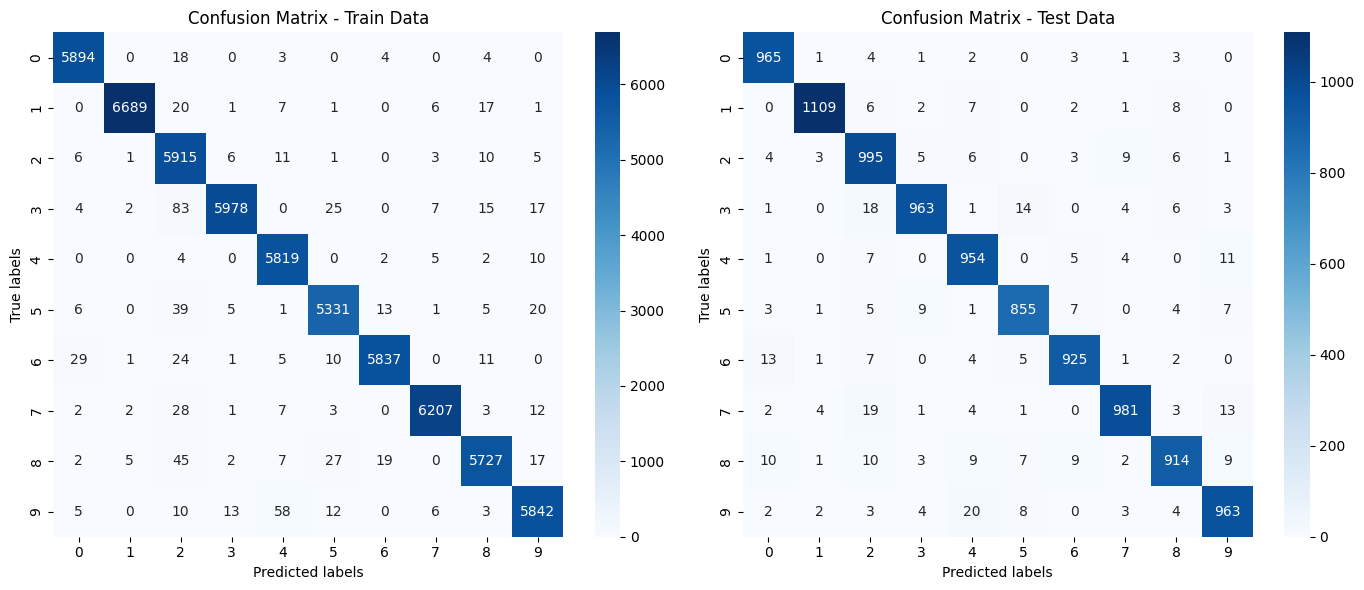

In [62]:
f1_train = f1_score(y_train, y_train_pred, average='macro')
f1_test = f1_score(y_test, y_test_pred, average='macro')
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)


print(f'Train F1 Score: {f1_train:.4f}')
print(f'Test F1 Score: {f1_test:.4f}')
print(f'\nTrain Accuracy: {train_accuracy:.4f}%')
print(f'Test Accuracy: {test_accuracy:.4f}%\n')



# Plot confusion matrices
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title('Confusion Matrix - Train Data')
axs[0].set_xlabel('Predicted labels')
axs[0].set_ylabel('True labels')

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axs[1])
axs[1].set_title('Confusion Matrix - Test Data')
axs[1].set_xlabel('Predicted labels')
axs[1].set_ylabel('True labels')



plt.tight_layout()
plt.show()

In [43]:
print('Test Data Classification Report:')
print(classification_report(y_test, y_test_pred))

Test Data Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.99      0.98      0.98      1135
           2       0.93      0.96      0.94      1032
           3       0.97      0.95      0.96      1010
           4       0.95      0.97      0.96       982
           5       0.96      0.96      0.96       892
           6       0.97      0.97      0.97       958
           7       0.98      0.95      0.96      1028
           8       0.96      0.94      0.95       974
           9       0.96      0.95      0.96      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



### Displaying the first 9 wrongly classified images with highest probability

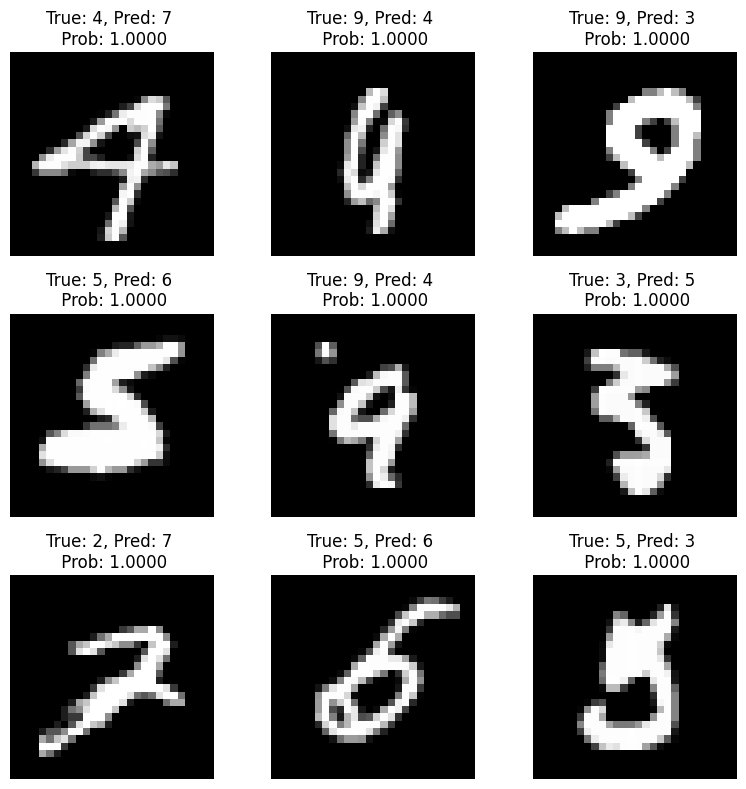

In [44]:
# Display the first k wrongly classified images with highest probability
k = 9
wrong_indices = np.where(np.array(y_test) != np.array(y_test_pred))[0]
wrong_prob = np.array(y_test_prob)[wrong_indices]
wrong_prob_max = np.max(wrong_prob, axis=1)
wrong_prob_indices = np.argsort(wrong_prob_max)[::-1][:k]

fig, axs = plt.subplots(3, 3, figsize=(8, 8))
for i, idx in enumerate(wrong_prob_indices):
    ax = axs[i // 3, i % 3]
    ax.imshow(X_test[wrong_indices[idx]], cmap='gray')
    ax.set_title(f'True: {y_test[wrong_indices[idx]]}, Pred: {y_test_pred[wrong_indices[idx]]} \n Prob: {wrong_prob_max[idx]:.4f}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Save the model checkpoint
torch.save(model.state_dict(), 'mlp_model.pkl')

# Load the model checkpoint
model = MLP().to(device)
model.load_state_dict(torch.load('mlp_model.pkl'))

## **Random Forest and Logistic Regression**

### Training the Random Forest model

In [ ]:


X_train = train_dataset.data.numpy().reshape(len(train_dataset), -1)
y_train = train_dataset.targets.numpy()

X_test = test_dataset.data.numpy().reshape(len(test_dataset), -1)
y_test = test_dataset.targets.numpy()

In [65]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [66]:
# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
rf_model.fit(X_train, y_train)
y_rf_pred = rf_model.predict(X_test)

print(f'Random Forest accuracy: {np.mean(y_rf_pred == y_test)}')

Random Forest accuracy: 0.9705


### Training the Logistic Regression model

In [67]:
# Train Logistics Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=0)
lr_model.fit(X_train_scaled, y_train)
y_lr_pred = lr_model.predict(X_test_scaled)

print(f'Logistic Regression accuracy: {np.mean(y_lr_pred == y_test)}')

Logistic Regression accuracy: 0.9216


### Performance Metrics

In [68]:
# F1 score and confusion matrix for Random Forest
f1_rf = f1_score(y_test, y_rf_pred, average='macro')

# F1 score and confusion matrix for Logistic Regression
f1_lr = f1_score(y_test, y_lr_pred, average='macro')

# Print F1 scores
print(f'Random Forest F1 Score: {f1_rf:.4f}')
print(f'Logistic Regression F1 Score: {f1_lr:.4f}')

Random Forest F1 Score: 0.9702
Logistic Regression F1 Score: 0.9205


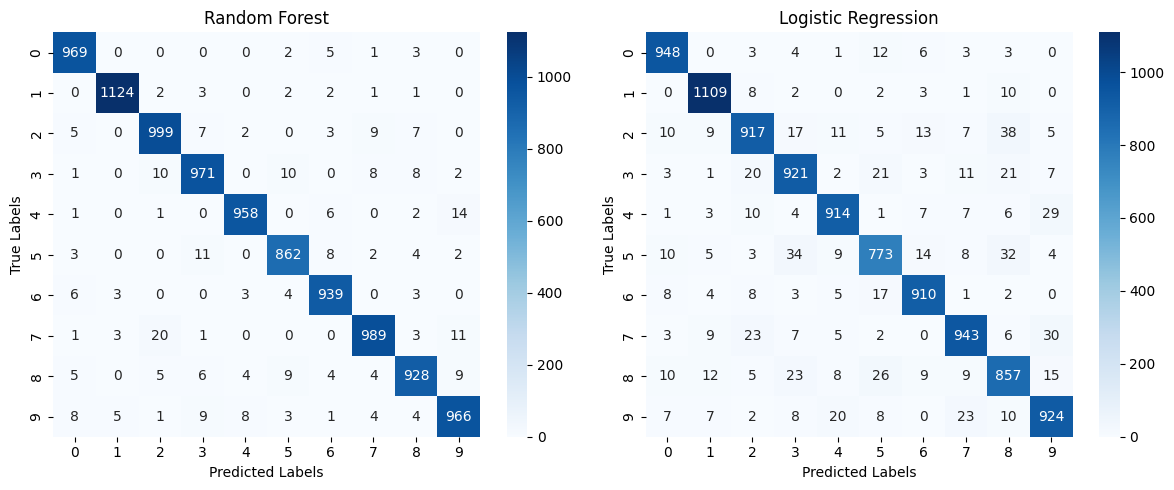

In [71]:
cm_rf = confusion_matrix(y_test, y_rf_pred)
cm_lr = confusion_matrix(y_test, y_lr_pred)


# Plot confusion matrices
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title('Random Forest')
axs[0].set_xlabel('Predicted Labels')
axs[0].set_ylabel('True Labels')

sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axs[1])
axs[1].set_title('Logistic Regression')
axs[1].set_xlabel('Predicted Labels')
axs[1].set_ylabel('True Labels')

plt.tight_layout()
plt.show()

In [72]:
print('Random Forest Classification Report')
print(classification_report(y_test, y_rf_pred))
print("-"*50)
print('\nLogistic Regression Classification Report')
print(classification_report(y_test, y_lr_pred))

Random Forest Classification Report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.97      1032
           3       0.96      0.96      0.96      1010
           4       0.98      0.98      0.98       982
           5       0.97      0.97      0.97       892
           6       0.97      0.98      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.96      0.95      0.96       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

--------------------------------------------------

Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
  

## Comparison between MLP, Random Forest and Logistic Regression

**Performance Metrics**

The table below shows the accuracy and F1 score on the test set provided in the MNIST dataset for all the three models:

| Model      | Accuracy | F1 Score |
|------------|----------|----------|
| MLP        | 96.24%     | 0.9622    |
| Random Forest   | 97.02%     | 0.9702    |
| Logistic Regression    | 92.16%     | 0.9205     |

**Confusions Matrices**

The confusion matrices for all the models on the test set are shown below:

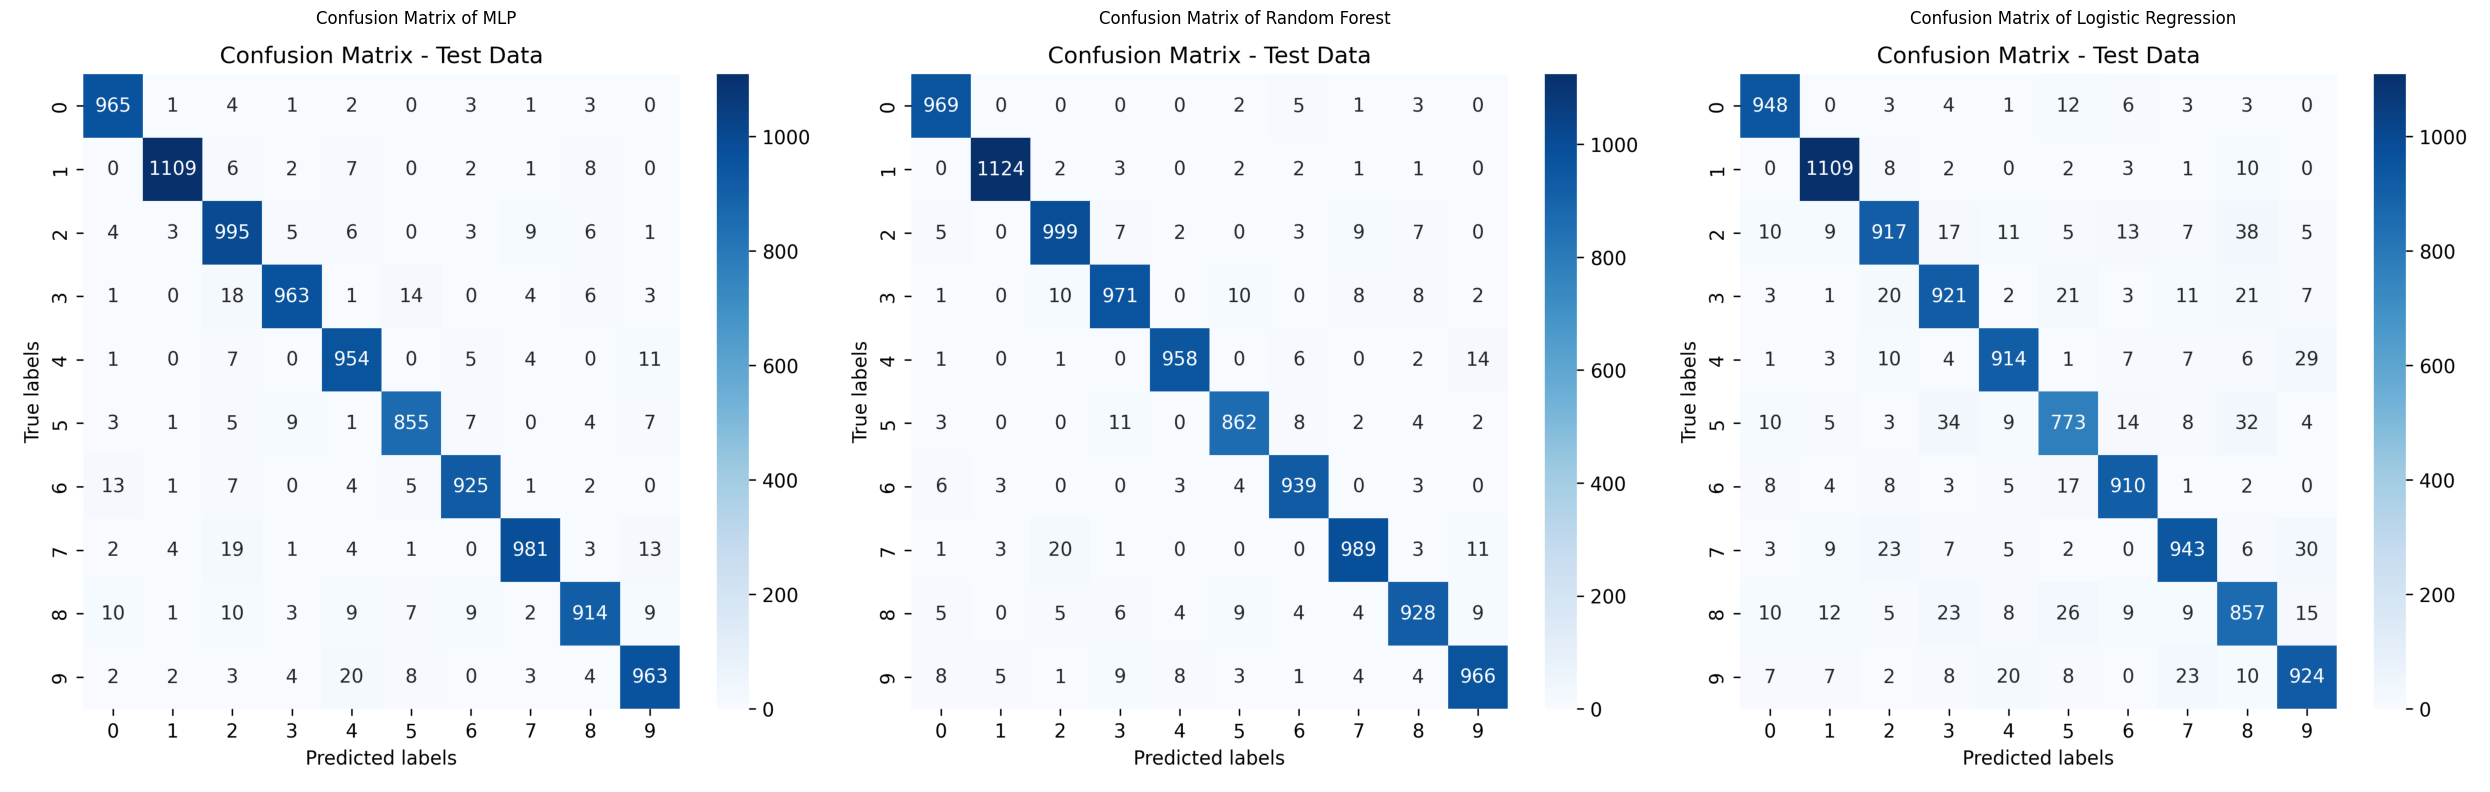

In [73]:
fig, axes = plt.subplots(1,3, figsize=(25, 15))
img = Image.open("/content/confusion_matrix_mlp.png")
axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title('Confusion Matrix of MLP')

img = Image.open("/content/confusion_matrix_rf.png")
axes[1].imshow(img)
axes[1].axis('off')
axes[1].set_title('Confusion Matrix of Random Forest')

img = Image.open("/content/confusion_matrix_lr.png")
axes[2].imshow(img)
axes[2].axis('off')
axes[2].set_title('Confusion Matrix of Logistic Regression')

plt.tight_layout()
plt.show()

### Observations

Based on the confusion matrices and the performance metrics provided, we can make the following observations:

1. **Random Forest**
   - **Accuracy**: 97.02%  
   - **F1 Score**: 0.9702  
   - The Random Forest model achieves the **highest accuracy and F1 score** among the three models, indicating the best overall performance on the test set.  
   - The confusion matrix shows **very few misclassifications**, suggesting the model has learned strong decision boundaries.  
   - **Commonly confused digits:** 2 and 7, 3 and 5.

2. **MLP (Multi-Layer Perceptron)**
   - **Accuracy**: 96.24%  
   - **F1 Score**: 0.9622  
   - The MLP performs slightly below the Random Forest but still achieves **high accuracy and F1 score**, showing that it effectively captures non-linear relationships in the data.  
   - The confusion matrix shows a few minor misclassifications.  
   - **Commonly confused digits:** 2 and 7, 3 and 5 (only a small number of errors).

3. **Logistic Regression**
   - **Accuracy**: 92.16%  
   - **F1 Score**: 0.9205  
   - The Logistic Regression model performs the weakest among the three, with the **lowest accuracy and F1 score**.  
   - The confusion matrix reveals the **highest number of misclassifications**, indicating it struggles to model complex, non-linear patterns.  
   - **Commonly confused digits:** 0 and 4, 0 and 7, 2 and 7, 2 and 8, 3 and 5, 3 and 8, 5 and 8, etc.


### Conclusions

Overall, the MLP model outperforms both the Random Forest and Logistic Regression models in terms of accuracy and F1 score, as well as having fewer misclassifications in the confusion matrix.

- The MLP, being a neural network with multiple layers, has a greater capacity to learn non-linear relationships in the data. This allows it to better differentiate between similar-looking digits and achieve fewer misclassifications.
- As an ensemble method, Random Forests generally perform well due to averaging across many decision trees, which reduces overfitting. However, it lacks the depth of MLP in capturing complex non-linear patterns, which leads to more frequent confusions between similar digits.
- Logistic Regression, as a linear model, is limited in its ability to capture complex patterns, thus making it the least effective for this data.